<a href="https://colab.research.google.com/github/gastonfloyd/prono/blob/main/Paran%C3%A1_Alerta_largoPlazo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elementos para informe

Se plantean herramientas para la toma de decisiones a dos escalas. En una escala operativa se cuenta con un pronóstico de niveles a 4 días, el cual surge de tener en cuenta el efecto de las mareas astronómicas y meteorológicas en el Río de la Plata. Este fenómeno se superpone a la condición hidrológica del río, que está condicionado por las crecidas o bajantes del Paraná.

Luego se tiene una escala de pronóstico a más largo plazo, orientada a la planificación de tareas de dragado. Estos niveles pronosticados estarán solo condicionados por el estado hidrológico de la cuenca del Paraná.

# Pronóstico Corto Plazo


El producto asociado a la escala operativa consta en 3 elementos:


*   Serie de niveles observada hasta la fecha en la que se consulta el pronóstico (en adelante, fecha actual)
*   Serie de niveles pronosticada antes y después de la fecha actual
*   Niveles de referencia

Los niveles de pronóstico pasado, sirven para contrastar con los datos observados y realizar una evaluación expeditiva de la performance de la herramienta.

Los niveles de referencia, permiten identificar posibles eventos pronosticados que tuvieran impacto en la operatoria normal del muelle.

Cabe destacar que este producto está referenciado al hidrómetro de Zárate, siendo conveniente en el futuro trasladarlo al sitio de VITCO. No obstante, para ser implementado directamente en el sitio es necesario contar con series de niveles horarias con transmisión en tiempo cuasi real.

A continuación se presenta una figura en la que se muestran los elementos antes mencionados. Se observa que el error del modelo se encuentra en el rango de +/- 0,3m.



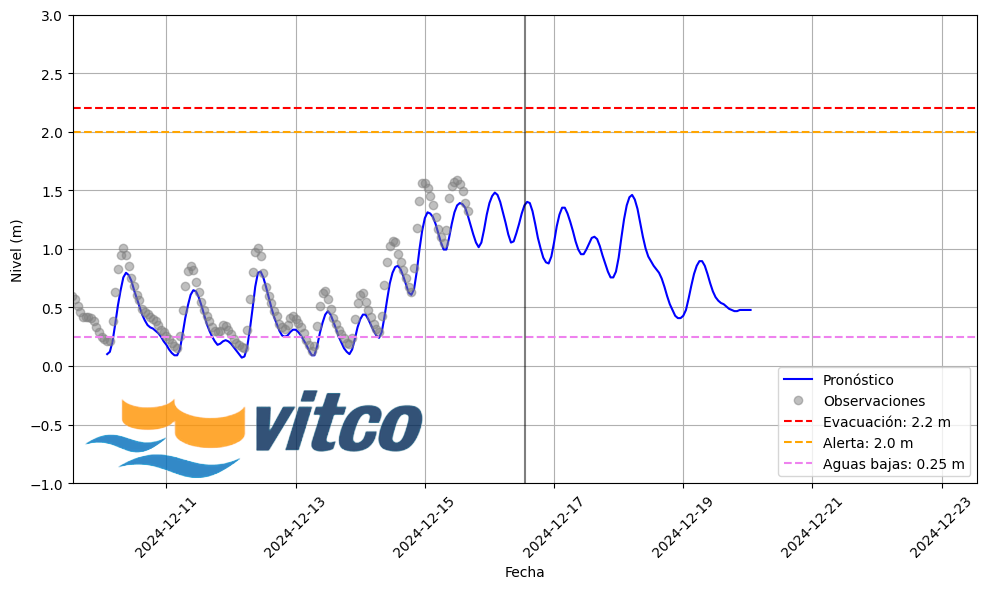

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from io import StringIO
from PIL import Image
from io import BytesIO

# URLs de la API
url_pronostico = "https://alerta.ina.gob.ar/a5/sim/calibrados?estacion_id=5907&var_id=2&includeCorr=true"
url_observaciones = "https://alerta.ina.gob.ar/a5/obs/puntual/series/29437/observaciones?&timestart=2024-11-01&timeend=2025-12-08&format=csvless&no_id=true"
url_logo = "https://directoriodecarga.com/imagenes/logo/vitco-logo_18157_220429010534.png"

# Definir los límites de fechas en el eje x
fecha_prono = datetime.now()
fecha_inicio = fecha_prono - timedelta(days = 7) #datetime(2024, 12, 1)
fecha_fin = fecha_prono + timedelta(days = 7) #datetime(2024, 12, 10)


# Hacer la solicitud
response = requests.get(url_pronostico)

# Revisar si la respuesta es exitosa
if response.status_code == 200:
    data = response.json()  # Convertir la respuesta a JSON

    # Crear una lista para almacenar los datos
    forecast_data = []

    # Recorrer las series en los datos de pronósticos
    for serie in data[0]['corrida']['series']:
        tipo = serie['qualifier']  # Identificar el tipo de pronóstico

        # Extraer los pronósticos
        for p in serie['pronosticos']:
            forecast_data.append({
                'fecha': datetime.fromisoformat(p['timestart'][:-1]),  # Convertir la fecha
                'valor': p['valor'],
                'tipo': tipo
            })

    # Crear un DataFrame con los datos
    df = pd.DataFrame(forecast_data)

    # Dividir el DataFrame en tres series: principal, p10 y p90
    df_main = df[df['tipo'] == 'main']
    df_p10 = df[df['tipo'] == 'p10']
    df_p90 = df[df['tipo'] == 'p90']

else:
    print(f"Error al consultar la API: {response.status_code}")


# Solicitud de observaciones
response_observaciones = requests.get(url_observaciones)



# Verificar respuesta de observaciones
if response_observaciones.status_code == 200:
    # Usar StringIO para convertir la respuesta en un objeto similar a un archivo
    data_observaciones = StringIO(response_observaciones.text)

    # Leer los datos desde el archivo simulado (StringIO)
    df_observaciones = pd.read_csv(data_observaciones,  names=['fecha', 'fecha_end', 'valor'], parse_dates=["fecha"])

    # Convertir la columna de fecha a formato datetime
    df_observaciones['fecha'] = pd.to_datetime(df_observaciones['fecha'])
else:
    print(f"Error al consultar observaciones: {response_observaciones.status_code}")


# Descargar el logo desde la URL
response_logo = requests.get(url_logo)
logo_img = Image.open(BytesIO(response_logo.content))

# Graficar los datos
plt.figure(figsize=(10, 6))

# Pronósticos y percentiles
plt.plot(df_main['fecha'], df_main['valor'], label='Pronóstico', color='blue')
#plt.fill_between(df_p10['fecha'], df_p10['valor'], df_p90['valor'], color='gray', alpha=0.3, label='Rango p10 - p90')

# Observaciones
plt.plot(df_observaciones['fecha'], df_observaciones['valor'], label='Observaciones', color='grey', linestyle='', marker='o',alpha=0.5)

    # Agregar líneas horizontales de referencia
plt.axhline(y=2.2, color='red', linestyle='--', label='Evacuación: 2.2 m')
plt.axhline(y=2.0, color='orange', linestyle='--', label='Alerta: 2.0 m')
plt.axhline(y=0.25, color='violet', linestyle='--', label='Aguas bajas: 0.25 m')


plt.axvline(x=fecha_prono, color='black', linestyle='-', alpha=0.5)

# Configurar el gráfico
#plt.title('Pronóstico de niveles con percentiles y observaciones')
plt.xlabel('Fecha')
plt.ylabel('Nivel (m)')
plt.legend(loc='lower right')
plt.grid(True)
plt.xticks(rotation=45)



# Configurar los límites
plt.xlim(fecha_inicio, fecha_fin)
plt.ylim(-1,3)

# Agregar el logo en el extremo superior derecho
logo_pos_x = 0.08  # Posición X en coordenadas normalizadas
logo_pos_y = 0.06  # Posición Y en coordenadas normalizadas
plt.figimage(logo_img, xo=plt.gcf().bbox.xmax*logo_pos_x, yo=plt.gcf().bbox.ymax*logo_pos_y, alpha=0.8, zorder=5)


# Mostrar la gráfica
plt.tight_layout()
plt.show()



# Pronosticos a largo plazo

El pronóstico a largo plazo se realiza a partir de la modelación hidrodinámica 1D que tiene en cuenta los río Paraná (desde Itaipú), Paraguay (desde Asunción), Iguazú (desde Andresito) y el Delta del Paraná (hasta la desembocadura en el Río de la Plata).

## Test

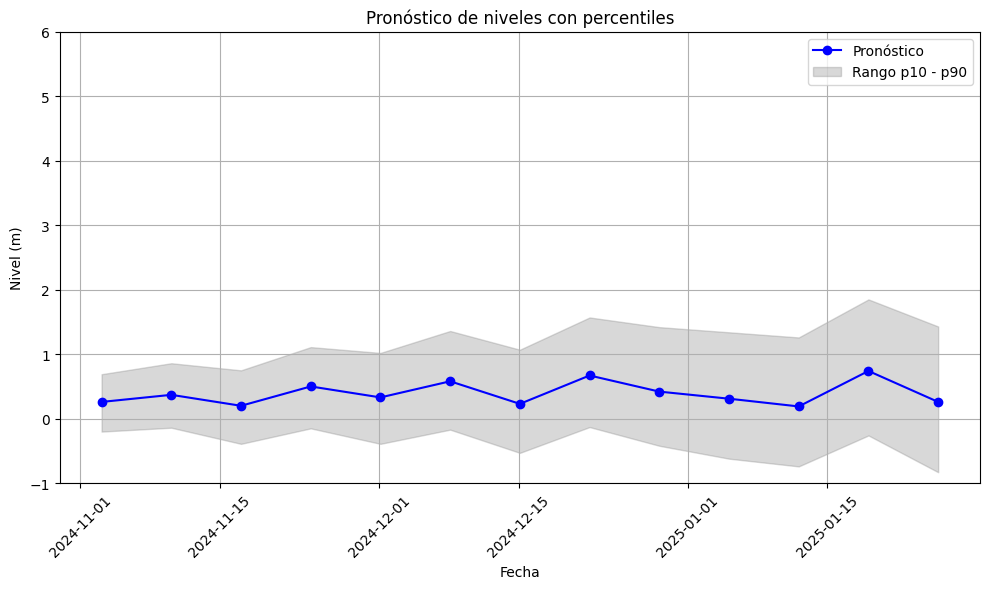

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# URL de la API
url = "https://alerta.ina.gob.ar/a5/sim/calibrados/499/corridas/last?estacion_id=40&includeProno=true"

# Hacer la solicitud
response = requests.get(url)

# Revisar si la respuesta es exitosa
if response.status_code == 200:
    data = response.json()  # Convertir la respuesta a JSON

    # Extraer las series de pronósticos
    pronosticos = data['series'][0]['pronosticos']

    # Crear una lista para almacenar los datos
    forecast_data = []

    # Recorrer los pronósticos y extraer la fecha y los valores
    for p in pronosticos:
        forecast_data.append({
            'fecha': datetime.fromisoformat(p['timestart'][:-1]),  # Convertir la fecha
            'valor': p['valor'],
            'tipo': p['qualifier']
        })

    # Crear un DataFrame con los datos
    df = pd.DataFrame(forecast_data)

    # Dividir el DataFrame en tres series: principal, p10 y p90
    df_main = df[df['tipo'] == 'main']
    df_p10 = df[df['tipo'] == 'p10']
    df_p90 = df[df['tipo'] == 'p90']

    # Graficar los datos
    plt.figure(figsize=(10, 6))

    plt.plot(df_main['fecha'], df_main['valor'], label='Pronóstico', color='blue', marker='o')
    plt.fill_between(df_p10['fecha'], df_p10['valor'], df_p90['valor'], color='gray', alpha=0.3, label='Rango p10 - p90')

    plt.title('Pronóstico de niveles con percentiles')
    plt.xlabel('Fecha')
    plt.ylabel('Nivel (m)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.ylim(-1.0, 6.0) # Para mantener misma escala siempre. Se resalta que estamos en aguas bajas

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

else:
    print(f"Error al consultar la API: {response.status_code}")






## Zarate

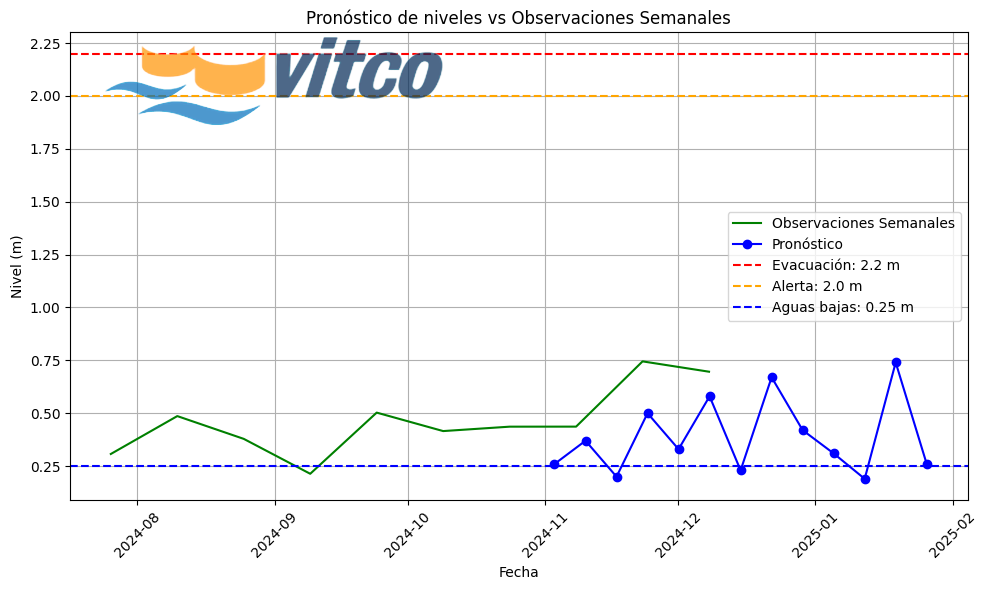

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime
from PIL import Image
from io import BytesIO

# URL de la API de pronósticos
url_pronosticos = "https://alerta.ina.gob.ar/a5/sim/calibrados/499/corridas/last?estacion_id=40&includeProno=true"
url_logo = "https://directoriodecarga.com/imagenes/logo/vitco-logo_18157_220429010534.png"


# URL de la API de observaciones
url_observaciones = "https://alerta.ina.gob.ar/a5/obs/puntual/series/29437/observaciones?&timestart=2024-07-26&timeend=2025-11-08&format=csvless&no_id=true"

# Hacer la solicitud de pronósticos
response_pronosticos = requests.get(url_pronosticos)

# Verificar si la respuesta es exitosa
if response_pronosticos.status_code == 200:
    data_pronosticos = response_pronosticos.json()  # Convertir la respuesta a JSON

    # Extraer las series de pronósticos
    pronosticos = data_pronosticos['series'][0]['pronosticos']

    # Crear una lista para almacenar los datos de pronósticos
    forecast_data = []

    # Recorrer los pronósticos y extraer la fecha y los valores
    for p in pronosticos:
        forecast_data.append({
            'fecha': datetime.fromisoformat(p['timestart'][:-1]),  # Convertir la fecha
            'valor': p['valor'],
            'tipo': p['qualifier']
        })

    # Crear un DataFrame con los datos de pronósticos
    df_pronosticos = pd.DataFrame(forecast_data)

    # Dividir el DataFrame en tres series: principal, p10 y p90
    df_main = df_pronosticos[df_pronosticos['tipo'] == 'main']
    df_p10 = df_pronosticos[df_pronosticos['tipo'] == 'p10']
    df_p90 = df_pronosticos[df_pronosticos['tipo'] == 'p90']
else:
    print(f"Error al consultar los pronósticos: {response_pronosticos.status_code}")

# Hacer la solicitud de observaciones
response_observaciones = requests.get(url_observaciones)

# Verificar si la respuesta es exitosa
if response_observaciones.status_code == 200:
    # Usar StringIO para convertir la respuesta en un objeto similar a un archivo
    data_observaciones = StringIO(response_observaciones.text)

    # Leer los datos desde el archivo simulado (StringIO)
    df_observaciones = pd.read_csv(data_observaciones, names=["fecha1", "fecha2", "valor"], parse_dates=["fecha1"])

    # Usamos solo la primera columna de fecha ('fecha1') para simplificar
    df_observaciones = df_observaciones[['fecha1', 'valor']]
    df_observaciones.rename(columns={'fecha1': 'fecha'}, inplace=True)

    # Promediar los datos observados semanalmente
    df_observaciones.set_index('fecha', inplace=True)  # Establecer la columna 'fecha' como índice
    df_observaciones_resampled = df_observaciones.resample('15D').mean()  # Promediar semanalmente
    df_observaciones_resampled.reset_index(inplace=True)  # Resetear el índice para facilitar la graficación



    # Descargar el logo desde la URL
    response_logo = requests.get(url_logo)
    logo_img = Image.open(BytesIO(response_logo.content))

    # Graficar los datos
    plt.figure(figsize=(10, 6))

    # Graficar las observaciones promediadas
    plt.plot(df_observaciones_resampled['fecha'], df_observaciones_resampled['valor'], label='Observaciones Semanales', color='green')#, marker='x')

    # Graficar los pronósticos
    plt.plot(df_main['fecha'], df_main['valor'], label='Pronóstico', color='blue', marker='o')
    #plt.fill_between(df_p10['fecha'], df_p10['valor'], df_p90['valor'], color='gray', alpha=0.3, label='Rango p10 - p90')

    # Agregar líneas horizontales de referencia
    plt.axhline(y=2.2, color='red', linestyle='--', label='Evacuación: 2.2 m')
    plt.axhline(y=2.0, color='orange', linestyle='--', label='Alerta: 2.0 m')
    plt.axhline(y=0.25, color='blue', linestyle='--', label='Aguas bajas: 0.25 m')

    # Configurar el gráfico
    plt.title('Pronóstico de niveles vs Observaciones Semanales')
    plt.xlabel('Fecha')
    plt.ylabel('Nivel (m)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)


    # Agregar el logo en el extremo superior derecho
    logo_pos_x = 0.10  # Posición X en coordenadas normalizadas
    logo_pos_y = 0.65  # Posición Y en coordenadas normalizadas
    plt.figimage(logo_img, xo=plt.gcf().bbox.xmax*logo_pos_x, yo=plt.gcf().bbox.ymax*logo_pos_y, alpha=0.7, zorder=10)



    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

else:
    print(f"Error al consultar las observaciones: {response_observaciones.status_code}")



## Corrientes

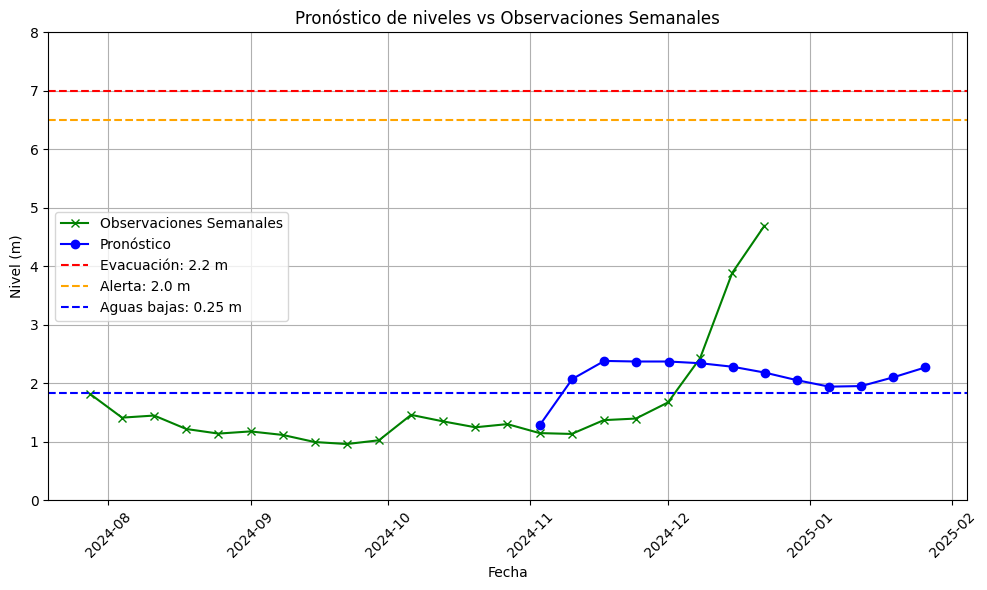

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime

# URL de la API de pronósticos
url_pronosticos = "https://alerta.ina.gob.ar/a5/sim/calibrados/499/corridas/last?estacion_id=19&includeProno=true"

# URL de la API de observaciones
url_observaciones = "https://alerta.ina.gob.ar/a5/obs/puntual/series/19/observaciones?&timestart=2024-07-26&timeend=2025-11-08&format=csvless&no_id=true"

# Hacer la solicitud de pronósticos
response_pronosticos = requests.get(url_pronosticos)

# Verificar si la respuesta es exitosa
if response_pronosticos.status_code == 200:
    data_pronosticos = response_pronosticos.json()  # Convertir la respuesta a JSON

    # Extraer las series de pronósticos
    pronosticos = data_pronosticos['series'][0]['pronosticos']

    # Crear una lista para almacenar los datos de pronósticos
    forecast_data = []

    # Recorrer los pronósticos y extraer la fecha y los valores
    for p in pronosticos:
        forecast_data.append({
            'fecha': datetime.fromisoformat(p['timestart'][:-1]),  # Convertir la fecha
            'valor': p['valor'],
            'tipo': p['qualifier']
        })

    # Crear un DataFrame con los datos de pronósticos
    df_pronosticos = pd.DataFrame(forecast_data)

    # Dividir el DataFrame en tres series: principal, p10 y p90
    df_main = df_pronosticos[df_pronosticos['tipo'] == 'main']
    df_p10 = df_pronosticos[df_pronosticos['tipo'] == 'p10']
    df_p90 = df_pronosticos[df_pronosticos['tipo'] == 'p90']
else:
    print(f"Error al consultar los pronósticos: {response_pronosticos.status_code}")

# Hacer la solicitud de observaciones
response_observaciones = requests.get(url_observaciones)

# Verificar si la respuesta es exitosa
if response_observaciones.status_code == 200:
    # Usar StringIO para convertir la respuesta en un objeto similar a un archivo
    data_observaciones = StringIO(response_observaciones.text)

    # Leer los datos desde el archivo simulado (StringIO)
    df_observaciones = pd.read_csv(data_observaciones, names=["fecha1", "fecha2", "valor"], parse_dates=["fecha1"])

    # Usamos solo la primera columna de fecha ('fecha1') para simplificar
    df_observaciones = df_observaciones[['fecha1', 'valor']]
    df_observaciones.rename(columns={'fecha1': 'fecha'}, inplace=True)

    # Promediar los datos observados semanalmente
    df_observaciones.set_index('fecha', inplace=True)  # Establecer la columna 'fecha' como índice
    df_observaciones_resampled = df_observaciones.resample('W').mean()  # Promediar semanalmente
    df_observaciones_resampled.reset_index(inplace=True)  # Resetear el índice para facilitar la graficación

    # Graficar los datos
    plt.figure(figsize=(10, 6))

    # Graficar las observaciones promediadas
    plt.plot(df_observaciones_resampled['fecha'], df_observaciones_resampled['valor'], label='Observaciones Semanales', color='green', marker='x')

    # Graficar los pronósticos
    plt.plot(df_main['fecha'], df_main['valor'], label='Pronóstico', color='blue', marker='o')
    #plt.fill_between(df_p10['fecha'], df_p10['valor'], df_p90['valor'], color='gray', alpha=0.3, label='Rango p10 - p90')

        # Agregar líneas horizontales de referencia
    plt.axhline(y=7, color='red', linestyle='--', label='Evacuación: 2.2 m')
    plt.axhline(y=6.5, color='orange', linestyle='--', label='Alerta: 2.0 m')
    plt.axhline(y=1.83, color='blue', linestyle='--', label='Aguas bajas: 0.25 m')

    # Configurar el gráfico
    plt.title('Pronóstico de niveles vs Observaciones Semanales')
    plt.xlabel('Fecha')
    plt.ylabel('Nivel (m)')
    plt.ylim(0,8)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

else:
    print(f"Error al consultar las observaciones: {response_observaciones.status_code}")



## Parana



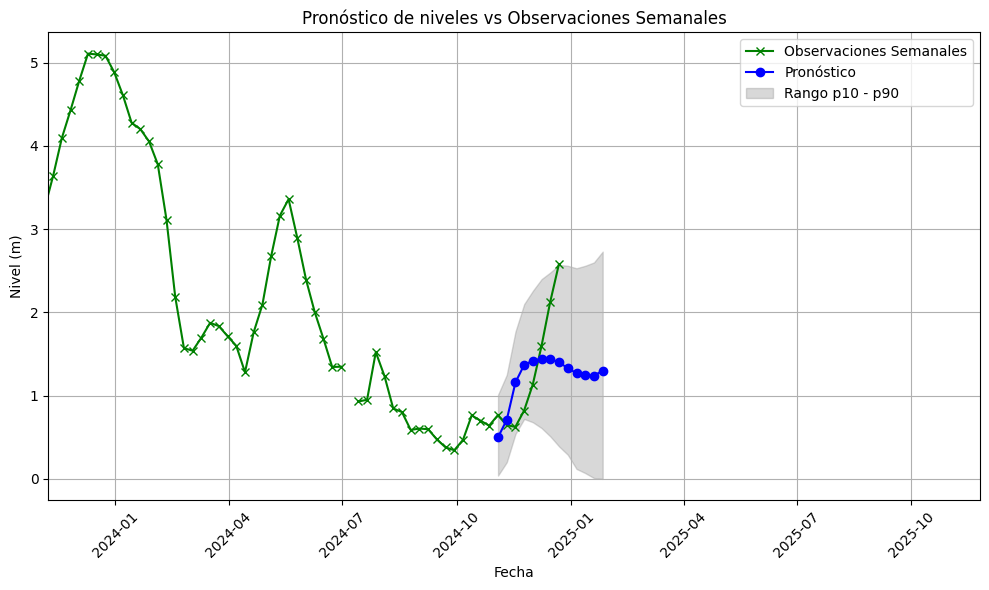

NameError: name 'np' is not defined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime

# URL de la API de pronósticos
url_pronosticos = "https://alerta.ina.gob.ar/a5/sim/calibrados/499/corridas/last?estacion_id=29&includeProno=true"

# URL de la API de observaciones
url_observaciones = "https://alerta.ina.gob.ar/a5/obs/puntual/series/29/observaciones?&timestart=2023-07-26&timeend=2025-11-08&format=csvless&no_id=true"

# Hacer la solicitud de pronósticos
response_pronosticos = requests.get(url_pronosticos)

# Verificar si la respuesta es exitosa
if response_pronosticos.status_code == 200:
    data_pronosticos = response_pronosticos.json()  # Convertir la respuesta a JSON

    # Extraer las series de pronósticos
    pronosticos = data_pronosticos['series'][0]['pronosticos']

    # Crear una lista para almacenar los datos de pronósticos
    forecast_data = []

    # Recorrer los pronósticos y extraer la fecha y los valores
    for p in pronosticos:
        forecast_data.append({
            'fecha': datetime.fromisoformat(p['timestart'][:-1]),  # Convertir la fecha
            'valor': p['valor'],
            'tipo': p['qualifier']
        })

    # Crear un DataFrame con los datos de pronósticos
    df_pronosticos = pd.DataFrame(forecast_data)

    # Dividir el DataFrame en tres series: principal, p10 y p90
    df_main = df_pronosticos[df_pronosticos['tipo'] == 'main']
    df_p10 = df_pronosticos[df_pronosticos['tipo'] == 'p10']
    df_p90 = df_pronosticos[df_pronosticos['tipo'] == 'p90']
else:
    print(f"Error al consultar los pronósticos: {response_pronosticos.status_code}")

# Hacer la solicitud de observaciones
response_observaciones = requests.get(url_observaciones)

# Verificar si la respuesta es exitosa
if response_observaciones.status_code == 200:
    # Usar StringIO para convertir la respuesta en un objeto similar a un archivo
    data_observaciones = StringIO(response_observaciones.text)

    # Leer los datos desde el archivo simulado (StringIO)
    df_observaciones = pd.read_csv(data_observaciones, names=["fecha1", "fecha2", "valor"], parse_dates=["fecha1"])

    # Usamos solo la primera columna de fecha ('fecha1') para simplificar
    df_observaciones = df_observaciones[['fecha1', 'valor']]
    df_observaciones.rename(columns={'fecha1': 'fecha'}, inplace=True)

    # Promediar los datos observados semanalmente
    df_observaciones.set_index('fecha', inplace=True)  # Establecer la columna 'fecha' como índice
    df_observaciones_resampled = df_observaciones.resample('W').mean()  # Promediar semanalmente
    df_observaciones_resampled.reset_index(inplace=True)  # Resetear el índice para facilitar la graficación

    # Graficar los datos
    plt.figure(figsize=(10, 6))

    # Graficar las observaciones promediadas
    plt.plot(df_observaciones_resampled['fecha'], df_observaciones_resampled['valor'], label='Observaciones Semanales', color='green', marker='x')

    # Graficar los pronósticos
    plt.plot(df_main['fecha'], df_main['valor'], label='Pronóstico', color='blue', marker='o')
    plt.fill_between(df_p10['fecha'], df_p10['valor'], df_p90['valor'], color='gray', alpha=0.3, label='Rango p10 - p90')

    # Configurar el gráfico
    plt.title('Pronóstico de niveles vs Observaciones Semanales')
    plt.xlabel('Fecha')
    plt.ylabel('Nivel (m)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Definir los límites de fechas en el eje x
    fecha_inicio = datetime(2023, 11, 8)
    fecha_fin = datetime(2025, 11, 25)

    # Configurar los límites en el eje x
    plt.xlim(fecha_inicio, fecha_fin)

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

else:
    print(f"Error al consultar las observaciones: {response_observaciones.status_code}")





# Función para calcular caudal en base a la altura
def altura_a_caudal(altura):
    if altura < 5.25:  # Se puede ajustar este umbral según el rango de alturas
        return np.exp((altura + 47.35) / 5.26)  # Ajuste logarítmico para Q < 22500
    else:
        return np.exp((altura + 27.19) / 3.26)  # Ajuste logarítmico para Q >= 22500

# Aplicar la función a las alturas pronosticadas
df_main['caudal_pronosticado'] = df_main['valor'].apply(altura_a_caudal)

# Imprimir valores para depuración
print("Alturas pronosticadas:", df_main['valor'].values)
print("Caudales pronosticados:", df_main['caudal_pronosticado'].values)



# Graficar los pronósticos de caudal
plt.figure(figsize=(10, 6))
plt.plot(df_main['fecha'], df_main['caudal_pronosticado'], label='Pronóstico de Caudal', color='blue', marker='o')
plt.xlabel('Fecha')
plt.ylabel('Caudal [m3/s]')
plt.title('Pronóstico de Caudal a partir de Alturas')
plt.legend()
plt.grid()
plt.show()

## Rosario

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime

# URL de la API de pronósticos
url_pronosticos = "https://alerta.ina.gob.ar/a5/sim/calibrados/499/corridas/last?estacion_id=34&includeProno=true"

# URL de la API de observaciones
url_observaciones = "https://alerta.ina.gob.ar/a5/obs/puntual/series/34/observaciones?&timestart=2024-07-26&timeend=2025-11-08&format=csvless&no_id=true"

# Hacer la solicitud de pronósticos
response_pronosticos = requests.get(url_pronosticos)

# Verificar si la respuesta es exitosa
if response_pronosticos.status_code == 200:
    data_pronosticos = response_pronosticos.json()  # Convertir la respuesta a JSON

    # Extraer las series de pronósticos
    pronosticos = data_pronosticos['series'][0]['pronosticos']

    # Crear una lista para almacenar los datos de pronósticos
    forecast_data = []

    # Recorrer los pronósticos y extraer la fecha y los valores
    for p in pronosticos:
        forecast_data.append({
            'fecha': datetime.fromisoformat(p['timestart'][:-1]),  # Convertir la fecha
            'valor': p['valor'],
            'tipo': p['qualifier']
        })

    # Crear un DataFrame con los datos de pronósticos
    df_pronosticos = pd.DataFrame(forecast_data)

    # Dividir el DataFrame en tres series: principal, p10 y p90
    df_main = df_pronosticos[df_pronosticos['tipo'] == 'main']
    df_p10 = df_pronosticos[df_pronosticos['tipo'] == 'p10']
    df_p90 = df_pronosticos[df_pronosticos['tipo'] == 'p90']
else:
    print(f"Error al consultar los pronósticos: {response_pronosticos.status_code}")

# Hacer la solicitud de observaciones
response_observaciones = requests.get(url_observaciones)

# Verificar si la respuesta es exitosa
if response_observaciones.status_code == 200:
    # Usar StringIO para convertir la respuesta en un objeto similar a un archivo
    data_observaciones = StringIO(response_observaciones.text)

    # Leer los datos desde el archivo simulado (StringIO)
    df_observaciones = pd.read_csv(data_observaciones, names=["fecha1", "fecha2", "valor"], parse_dates=["fecha1"])

    # Usamos solo la primera columna de fecha ('fecha1') para simplificar
    df_observaciones = df_observaciones[['fecha1', 'valor']]
    df_observaciones.rename(columns={'fecha1': 'fecha'}, inplace=True)

    # Promediar los datos observados semanalmente
    df_observaciones.set_index('fecha', inplace=True)  # Establecer la columna 'fecha' como índice
    df_observaciones_resampled = df_observaciones.resample('W').mean()  # Promediar semanalmente
    df_observaciones_resampled.reset_index(inplace=True)  # Resetear el índice para facilitar la graficación

    # Graficar los datos
    plt.figure(figsize=(10, 6))

    # Graficar las observaciones promediadas
    plt.plot(df_observaciones_resampled['fecha'], df_observaciones_resampled['valor'], label='Observaciones Semanales', color='green', marker='x')

    # Graficar los pronósticos
    plt.plot(df_main['fecha'], df_main['valor']+0.0, label='Pronóstico', color='blue', marker='o')
    plt.fill_between(df_p10['fecha'], df_p10['valor'], df_p90['valor'], color='gray', alpha=0.3, label='Rango p10 - p90')

    # Configurar el gráfico
    plt.title('Pronóstico de niveles vs Observaciones Semanales')
    plt.xlabel('Fecha')
    plt.ylabel('Nivel (m)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

else:
    print(f"Error al consultar las observaciones: {response_observaciones.status_code}")

# Sedimentos

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Monta tu Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 4001_Zarate.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')

# Paso 3: Graficar cada variable en función del tiempo
fig, axs = plt.subplots(4, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Datos Históricos - Estación 4001 - Zárate', fontsize=16)

# Altura Escala
axs[0].plot(df['Fecha y Hora'], df['Altura Escala [m]'], color='b', label='Altura Escala [m]')
axs[0].set_ylabel('Altura Escala [m]')
axs[0].legend()

# Caudal Líquido
axs[1].plot(df['Fecha y Hora'], df['Caudal Líquido [m3/s]'], color='g', label='Caudal Líquido [m3/s]')
axs[1].set_ylabel('Caudal Líquido [m3/s]')
axs[1].legend()

# Caudal Sólido Grueso
axs[2].plot(df['Fecha y Hora'], df['Caudal Sólido Grueso [kg/s]'], color='r', label='Caudal Sólido Grueso [kg/s]')
axs[2].set_ylabel('Caudal Sólido Grueso [kg/s]')
axs[2].legend()

# Caudal Sólido Fino
axs[3].plot(df['Fecha y Hora'], df['Caudal Sólido Fino [kg/s]'], color='m', label='Caudal Sólido Fino [kg/s]')
axs[3].set_ylabel('Caudal Sólido Fino [kg/s]')
axs[3].legend()

plt.tight_layout()
plt.show()


# Paso 4: Graficar Caudal Líquido vs Caudal Sólido Grueso y Fino en escala log-log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Q Líquido vs Q Sólido Grueso en escala log-log
mask_grueso = ~np.isnan(df['Caudal Líquido [m3/s]']) & ~np.isnan(df['Caudal Sólido Grueso [kg/s]'])
ql_grueso = df['Caudal Líquido [m3/s]'][mask_grueso]
qs_grueso = df['Caudal Sólido Grueso [kg/s]'][mask_grueso]

ax1.scatter(ql_grueso, qs_grueso, color='r', label='Q Líquido vs Q Sólido Grueso')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Caudal Líquido [m3/s]')
ax1.set_ylabel('Caudal Sólido Grueso [kg/s]')
ax1.set_title('Q Líquido vs Q Sólido Grueso')

# Ajuste en log-log
slope, intercept, _, _, _ = linregress(np.log10(ql_grueso), np.log10(qs_grueso))
ql_fit = np.linspace(ql_grueso.min(), ql_grueso.max(), 100)
qs_fit = 10**(intercept + slope * np.log10(ql_fit))
ax1.plot(ql_fit, qs_fit, color='black', linestyle='--', label=f'Ajuste: y = {10**intercept:.2f} * x^{slope:.2f}')
ax1.legend()

slope_grueso, intercept_grueso, _, _, _ = linregress(np.log10(ql_grueso), np.log10(qs_grueso))
print(f"Expresión ajuste Q Líquido vs Q Sólido Grueso: y = {10**intercept_grueso:.2f} * x^{slope_grueso:.2f}")


# Caudal Líquido vs Caudal Sólido Fino
ax2.scatter(df['Caudal Líquido [m3/s]'], df['Caudal Sólido Fino [kg/s]'], color='m', label='Q Líquido vs Q Sólido Fino')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Caudal Líquido [m3/s]')
ax2.set_ylabel('Caudal Sólido Fino [kg/s]')
ax2.set_title('Q Líquido vs Q Sólido Fino')
ax2.legend()

plt.tight_layout()
plt.show()

## **Zarate**

### HQ Zarate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ajuste Potencial para Q < 5000: y = 1.0584e-04 * x^1.0527e+00 (R² = 0.2119)
Ajuste Polinómico para Q < 5000: y = -6.58e-12*x^3 + 1.41e-07*x^2 + -7.06e-04*x + 1.60 (R² = 0.0583)
Ajuste Logarítmico para Q < 5000: y = 0.53*ln(x) + -3.69 (R² = 0.1461)



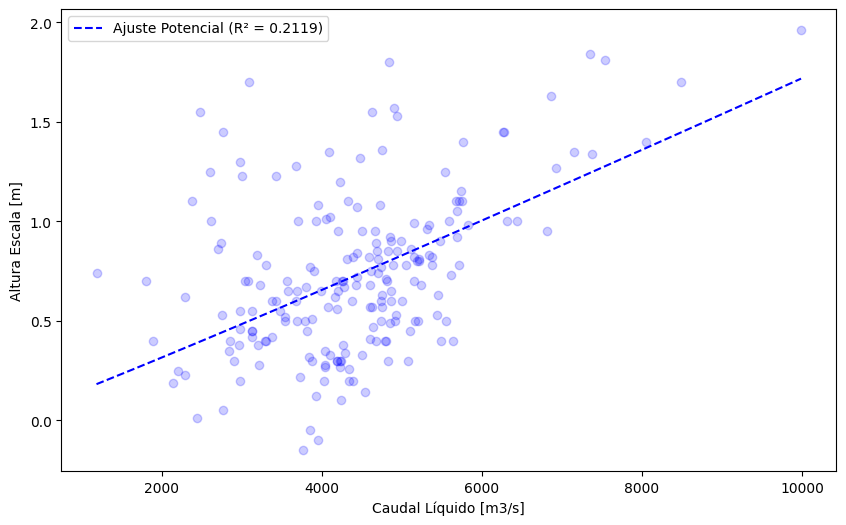

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


# Monta tu Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 4001_Zarate.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')





# Definir el umbral
Umbral = 5000

# Definir funciones de ajuste
def potencial(x, a, b):
    return a * x ** b

def polinomica(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def logaritmica(x, a, b):
    return a * np.log(x) + b

# Filtrar valores no nulos y caudales menores a 1000
mask = ~df['Caudal Líquido [m3/s]'].isna() & ~df['Altura Escala [m]'].isna() & (df['Caudal Líquido [m3/s]'] >= 1000)
caudal = df['Caudal Líquido [m3/s]'][mask]
altura = df['Altura Escala [m]'][mask]


# Función para realizar el ajuste y calcular R²
def ajustar_modelo(func, x, y):
    params, _ = curve_fit(func, x, y)
    y_pred = func(x, *params)
    r2 = r2_score(y, y_pred)
    return params, r2, y_pred

# Ajustes para caudal menor a Umbral
params_pot, r2_pot, altura_pot = ajustar_modelo(potencial, caudal, altura)
params_pol, r2_pol, altura_pol = ajustar_modelo(polinomica, caudal, altura)
params_log, r2_log, altura_log = ajustar_modelo(logaritmica, caudal, altura)



# Mostrar las expresiones de los ajustes y R2 en la consola
print(f"Ajuste Potencial para Q < {Umbral}: y = {params_pot[0]:.4e} * x^{params_pot[1]:.4e} (R² = {r2_pot:.4f})")
print(f"Ajuste Polinómico para Q < {Umbral}: y = {params_pol[0]:.2e}*x^3 + {params_pol[1]:.2e}*x^2 + {params_pol[2]:.2e}*x + {params_pol[3]:.2f} (R² = {r2_pol_menor:.4f})")
print(f"Ajuste Logarítmico para Q < {Umbral}: y = {params_log[0]:.2f}*ln(x) + {params_log[1]:.2f} (R² = {r2_log:.4f})\n")


# Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.scatter(caudal, altura, color='blue', alpha=0.2)
ax1.set_xlabel('Caudal Líquido [m3/s]')
ax1.set_ylabel('Altura Escala [m]')

# Generar valores de x para las curvas de ajuste
caudal_fit = np.linspace(caudal.min(), caudal.max(), 100)

# Agregar las curvas de ajuste
ax1.plot(caudal_fit, potencial(caudal_fit, *params_pot), color='blue', linestyle='--',
         label=f'Ajuste Potencial (R² = {r2_pot:.4f})')
#ax1.plot(caudal_fit, polinomica(caudal_fit, *params_pol), color='blue', linestyle=':',
#         label=f'Ajuste Polinómico  (R² = {r2_pol:.4f})')
#ax1.plot(caudal_fit, logaritmica(caudal_fit, *params_log), color='blue', linestyle='-.',
#         label=f'Ajuste Logarítmico  (R² = {r2_log:.4f})')

ax1.legend()
plt.show()




### Analisis relacion Parana Zarate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


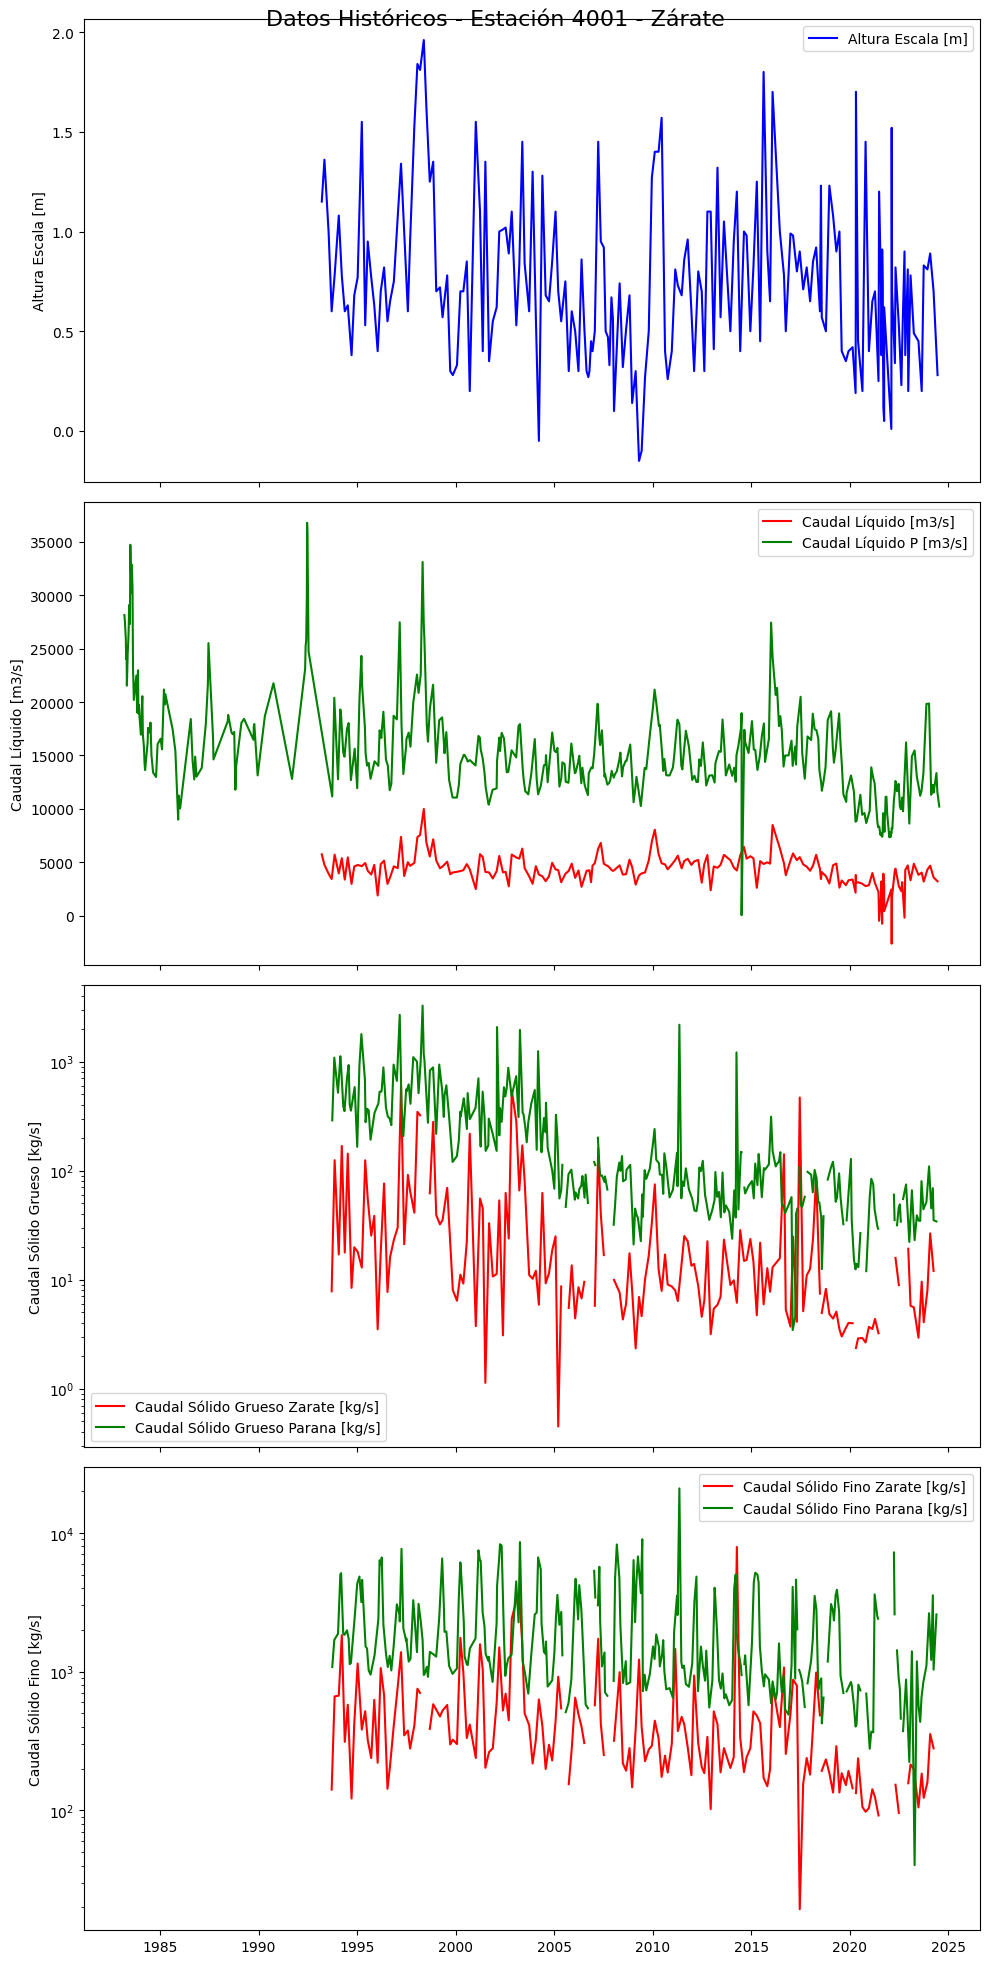

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Monta tu Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 4001_Zarate.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')






# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path_p = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 2602 - Aforos Parana.csv'
df_p = pd.read_csv(file_path_p, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df_p.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df_p['Fecha y Hora'] = pd.to_datetime(df_p['Fecha y Hora'], format='%d/%m/%Y %H:%M')





# Paso 3: Graficar cada variable en función del tiempo
fig, axs = plt.subplots(4, 1, figsize=(10, 20), sharex=True)
fig.suptitle('Datos Históricos - Estación 4001 - Zárate', fontsize=16)

# Altura Escala
axs[0].plot(df['Fecha y Hora'], df['Altura Escala [m]'], color='b', label='Altura Escala [m]')
axs[0].set_ylabel('Altura Escala [m]')
axs[0].legend()

# Caudal Líquido
axs[1].plot(df['Fecha y Hora'], df['Caudal Líquido [m3/s]'], color='r', label='Caudal Líquido [m3/s]')
axs[1].plot(df_p['Fecha y Hora'], df_p['Caudal Líquido [m3/s]'], color='g', label='Caudal Líquido P [m3/s]')
axs[1].set_ylabel('Caudal Líquido [m3/s]')
axs[1].legend()

# Caudal Sólido Grueso
axs[2].plot(df['Fecha y Hora'], df['Caudal Sólido Grueso [kg/s]'], color='r', label='Caudal Sólido Grueso Zarate [kg/s]')
axs[2].plot(df_p['Fecha y Hora'], df_p['Caudal Sólido Grueso [kg/s]'], color='g', label='Caudal Sólido Grueso Parana [kg/s]')
axs[2].set_ylabel('Caudal Sólido Grueso [kg/s]')
axs[2].set_yscale('log')
axs[2].legend()

# Caudal Sólido Fino
axs[3].plot(df['Fecha y Hora'], df['Caudal Sólido Fino [kg/s]'], color='r', label='Caudal Sólido Fino Zarate [kg/s]')
axs[3].plot(df_p['Fecha y Hora'], df_p['Caudal Sólido Fino [kg/s]'], color='g', label='Caudal Sólido Fino Parana [kg/s]')
axs[3].set_ylabel('Caudal Sólido Fino [kg/s]')
axs[3].set_yscale('log')
axs[3].legend()

plt.tight_layout()
plt.show()





## Parana

### Ajuste HQ

Mounted at /content/drive
Ajuste Potencial para Q < 22500: y = 0.00 * x^1.81 (R² = 0.9046)
Ajuste Polinómico para Q < 22500: y = 3.72e-13*x^3 + -2.77e-08*x^2 + 9.41e-04*x + -5.95 (R² = 0.9658)
Ajuste Logarítmico para Q < 22500: y = 5.26*ln(x) + -47.35 (R² = 0.9648)

Ajuste Potencial para Q >= 22500: y = 0.03 * x^0.51 (R² = 0.6035)
Ajuste Polinómico para Q >= 22500: y = 6.94e-13*x^3 + -7.04e-08*x^2 + 2.42e-03*x + -21.52 (R² = 0.6693)
Ajuste Logarítmico para Q >= 22500: y = 3.26*ln(x) + -27.19 (R² = 0.6171)


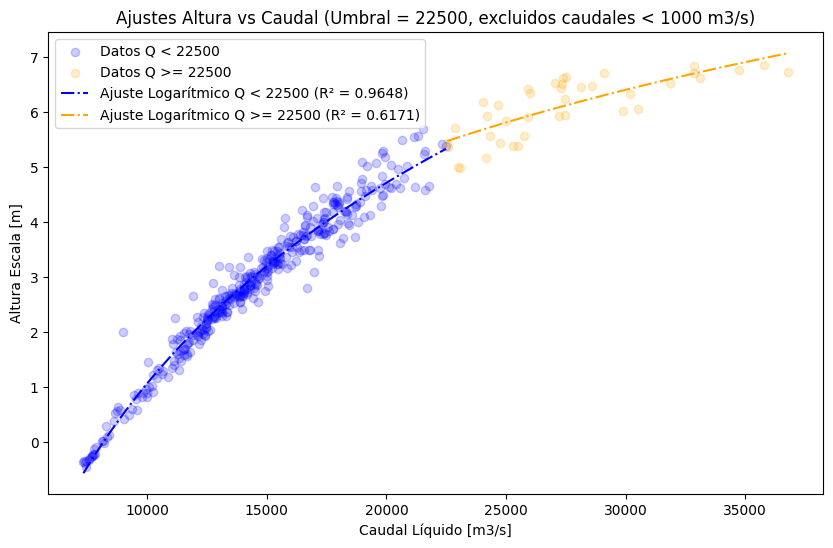

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Monta tu Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 2602 - Aforos Parana.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')






# Definir el umbral
Umbral = 22500

# Definir funciones de ajuste
def potencial(x, a, b):
    return a * x ** b

def polinomica(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def logaritmica(x, a, b):
    return a * np.log(x) + b

# Filtrar valores no nulos y caudales menores a 1000
mask = ~df['Caudal Líquido [m3/s]'].isna() & ~df['Altura Escala [m]'].isna() & (df['Caudal Líquido [m3/s]'] >= 1000)
caudal = df['Caudal Líquido [m3/s]'][mask]
altura = df['Altura Escala [m]'][mask]

# Dividir en dos subconjuntos según el caudal
caudal_menor = caudal[caudal < Umbral]
altura_menor = altura[caudal < Umbral]

caudal_mayor = caudal[caudal >= Umbral]
altura_mayor = altura[caudal >= Umbral]

# Función para realizar el ajuste y calcular R²
def ajustar_modelo(func, x, y):
    params, _ = curve_fit(func, x, y)
    y_pred = func(x, *params)
    r2 = r2_score(y, y_pred)
    return params, r2, y_pred

# Ajustes para caudal menor a Umbral
params_pot_menor, r2_pot_menor, altura_pot_menor = ajustar_modelo(potencial, caudal_menor, altura_menor)
params_pol_menor, r2_pol_menor, altura_pol_menor = ajustar_modelo(polinomica, caudal_menor, altura_menor)
params_log_menor, r2_log_menor, altura_log_menor = ajustar_modelo(logaritmica, caudal_menor, altura_menor)

# Ajustes para caudal mayor o igual a Umbral
params_pot_mayor, r2_pot_mayor, altura_pot_mayor = ajustar_modelo(potencial, caudal_mayor, altura_mayor)
params_pol_mayor, r2_pol_mayor, altura_pol_mayor = ajustar_modelo(polinomica, caudal_mayor, altura_mayor)
params_log_mayor, r2_log_mayor, altura_log_mayor = ajustar_modelo(logaritmica, caudal_mayor, altura_mayor)

# Mostrar las expresiones de los ajustes y R2 en la consola
print(f"Ajuste Potencial para Q < {Umbral}: y = {params_pot_menor[0]:.2f} * x^{params_pot_menor[1]:.2f} (R² = {r2_pot_menor:.4f})")
print(f"Ajuste Polinómico para Q < {Umbral}: y = {params_pol_menor[0]:.2e}*x^3 + {params_pol_menor[1]:.2e}*x^2 + {params_pol_menor[2]:.2e}*x + {params_pol_menor[3]:.2f} (R² = {r2_pol_menor:.4f})")
print(f"Ajuste Logarítmico para Q < {Umbral}: y = {params_log_menor[0]:.2f}*ln(x) + {params_log_menor[1]:.2f} (R² = {r2_log_menor:.4f})\n")

print(f"Ajuste Potencial para Q >= {Umbral}: y = {params_pot_mayor[0]:.2f} * x^{params_pot_mayor[1]:.2f} (R² = {r2_pot_mayor:.4f})")
print(f"Ajuste Polinómico para Q >= {Umbral}: y = {params_pol_mayor[0]:.2e}*x^3 + {params_pol_mayor[1]:.2e}*x^2 + {params_pol_mayor[2]:.2e}*x + {params_pol_mayor[3]:.2f} (R² = {r2_pol_mayor:.4f})")
print(f"Ajuste Logarítmico para Q >= {Umbral}: y = {params_log_mayor[0]:.2f}*ln(x) + {params_log_mayor[1]:.2f} (R² = {r2_log_mayor:.4f})")

# Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.scatter(caudal_menor, altura_menor, color='blue', label=f'Datos Q < {Umbral}', alpha=0.2)
ax1.scatter(caudal_mayor, altura_mayor, color='orange', label=f'Datos Q >= {Umbral}', alpha=0.2)
ax1.set_xlabel('Caudal Líquido [m3/s]')
ax1.set_ylabel('Altura Escala [m]')
ax1.set_title(f'Ajustes Altura vs Caudal (Umbral = {Umbral}, excluidos caudales < 1000 m3/s)')

# Generar valores de x para las curvas de ajuste
caudal_fit_menor = np.linspace(caudal_menor.min(), caudal_menor.max(), 100)
caudal_fit_mayor = np.linspace(caudal_mayor.min(), caudal_mayor.max(), 100)

# Agregar las curvas de ajuste
#ax1.plot(caudal_fit_menor, potencial(caudal_fit_menor, *params_pot_menor), color='blue', linestyle='--',
#         label=f'Ajuste Potencial Q < {Umbral} (R² = {r2_pot_menor:.4f})')
#ax1.plot(caudal_fit_menor, polinomica(caudal_fit_menor, *params_pol_menor), color='blue', linestyle=':',
#         label=f'Ajuste Polinómico Q < {Umbral} (R² = {r2_pol_menor:.4f})')
ax1.plot(caudal_fit_menor, logaritmica(caudal_fit_menor, *params_log_menor), color='blue', linestyle='-.',
         label=f'Ajuste Logarítmico Q < {Umbral} (R² = {r2_log_menor:.4f})')

#ax1.plot(caudal_fit_mayor, potencial(caudal_fit_mayor, *params_pot_mayor), color='orange', linestyle='--',
#         label=f'Ajuste Potencial Q >= {Umbral} (R² = {r2_pot_mayor:.4f})')
#ax1.plot(caudal_fit_mayor, polinomica(caudal_fit_mayor, *params_pol_mayor), color='orange', linestyle=':',
#         label=f'Ajuste Polinómico Q >= {Umbral} (R² = {r2_pol_mayor:.4f})')
ax1.plot(caudal_fit_mayor, logaritmica(caudal_fit_mayor, *params_log_mayor), color='orange', linestyle='-.',
         label=f'Ajuste Logarítmico Q >= {Umbral} (R² = {r2_log_mayor:.4f})')

ax1.legend()
plt.show()

### Series

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


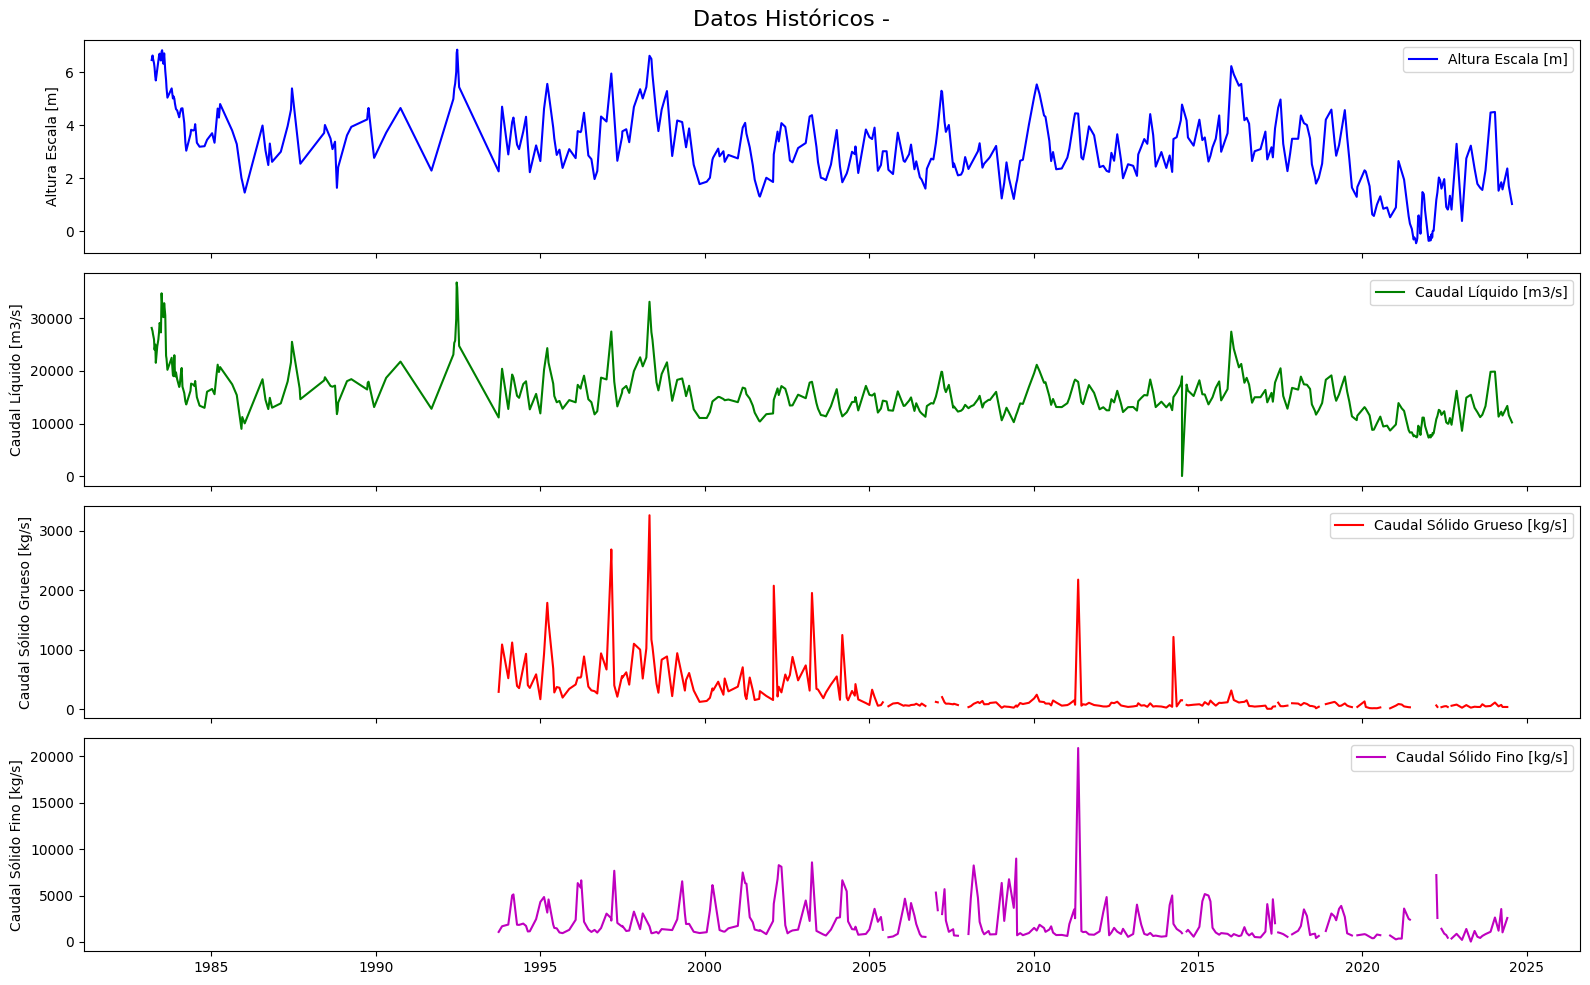

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Paso 1: Montar Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 2602 - Aforos Parana.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')

# Filtro 1: Filtrar datos por fecha
df_grueso = df[df['Fecha y Hora'].dt.year > 2005].copy()
df_fino = df[df['Fecha y Hora'].dt.year > 1990].copy()

# Filtro 2: Eliminar valores nulos en las columnas necesarias
df_grueso = df_grueso.dropna(subset=['Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]'])
df_fino = df_fino.dropna(subset=['Caudal Líquido [m3/s]', 'Caudal Sólido Fino [kg/s]'])


# Paso 3: Graficar cada variable en función del tiempo
fig, axs = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
fig.suptitle('Datos Históricos - ', fontsize=16)

# Altura Escala
axs[0].plot(df['Fecha y Hora'], df['Altura Escala [m]'], color='b', label='Altura Escala [m]')
axs[0].set_ylabel('Altura Escala [m]')
axs[0].legend()

# Caudal Líquido
axs[1].plot(df['Fecha y Hora'], df['Caudal Líquido [m3/s]'], color='g', label='Caudal Líquido [m3/s]')
axs[1].set_ylabel('Caudal Líquido [m3/s]')
axs[1].legend()

# Caudal Sólido Grueso
axs[2].plot(df['Fecha y Hora'], df['Caudal Sólido Grueso [kg/s]'], color='r', label='Caudal Sólido Grueso [kg/s]')
axs[2].set_ylabel('Caudal Sólido Grueso [kg/s]')
axs[2].legend()

# Caudal Sólido Fino
axs[3].plot(df['Fecha y Hora'], df['Caudal Sólido Fino [kg/s]'], color='m', label='Caudal Sólido Fino [kg/s]')
axs[3].set_ylabel('Caudal Sólido Fino [kg/s]')
axs[3].legend()

plt.tight_layout()
plt.show()




### Ajuste Sedimentos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ajuste Grueso: y = 1.46e-06 * x^1.84, R² = 0.31
Ajuste Fino: y = 6.23e-01 * x^0.81, R² = 0.05


<ipython-input-26-6ca19497b42b>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
<ipython-input-26-6ca19497b42b>:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter1 = ax1.scatter(x_grueso, y_grueso, c=colors_grueso, cmap='viridis', label='Q Líquido vs Q Sólido Grueso')
<ipython-input-26-6ca19497b42b>:75: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter2 = ax2.scatter(x_fino, y_fino, c=colors_fino, cmap='viridis', label='Q Líquido vs Q Sólido Fino')


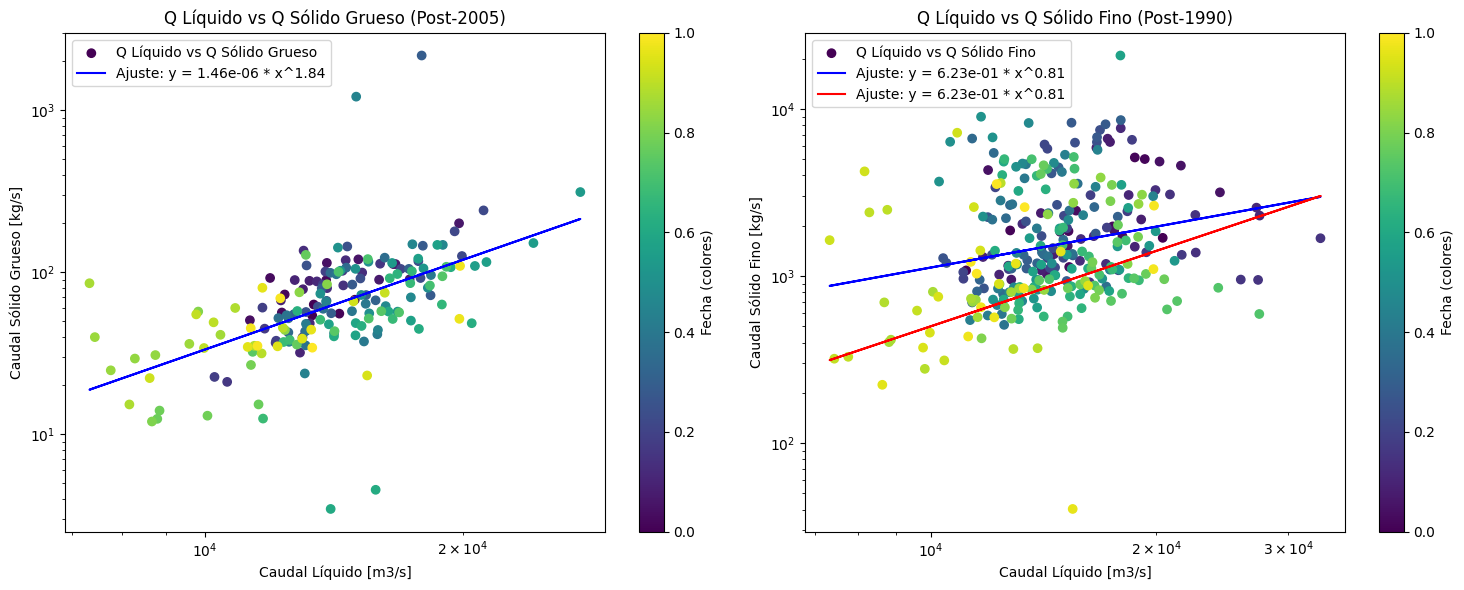

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Paso 1: Montar Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 2602 - Aforos Parana.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')

# Filtro 1: Filtrar datos por fecha
df_grueso = df[df['Fecha y Hora'].dt.year > 2005].copy()
df_fino = df[df['Fecha y Hora'].dt.year > 1990].copy()

# Filtro 2: Eliminar valores nulos en las columnas necesarias
df_grueso = df_grueso.dropna(subset=['Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]'])
df_fino = df_fino.dropna(subset=['Caudal Líquido [m3/s]', 'Caudal Sólido Fino [kg/s]'])


from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Normalizar las fechas para asociar colores
norm_grueso = Normalize(vmin=df_grueso['Fecha y Hora'].min().timestamp(), vmax=df_grueso['Fecha y Hora'].max().timestamp())
norm_fino = Normalize(vmin=df_fino['Fecha y Hora'].min().timestamp(), vmax=df_fino['Fecha y Hora'].max().timestamp())
cmap = cm.get_cmap('viridis')

colors_grueso = cmap(norm_grueso(df_grueso['Fecha y Hora'].map(lambda x: x.timestamp())))
colors_fino = cmap(norm_fino(df_fino['Fecha y Hora'].map(lambda x: x.timestamp())))

# Ajuste lineal (log-log)
def ajuste_lineal(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    return slope, intercept, r_value

# Gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Caudal Líquido vs Caudal Sólido Grueso
x_grueso = df_grueso['Caudal Líquido [m3/s]']
y_grueso = df_grueso['Caudal Sólido Grueso [kg/s]']
slope_g, intercept_g, r_value_g = ajuste_lineal(x_grueso, y_grueso)

scatter1 = ax1.scatter(x_grueso, y_grueso, c=colors_grueso, cmap='viridis', label='Q Líquido vs Q Sólido Grueso')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Caudal Líquido [m3/s]')
ax1.set_ylabel('Caudal Sólido Grueso [kg/s]')
ax1.set_title('Q Líquido vs Q Sólido Grueso (Post-2005)')
ax1.plot(x_grueso, 10**(intercept_g + slope_g * np.log10(x_grueso)), color='blue', label=f'Ajuste: y = {10**intercept_g:.2e} * x^{slope_g:.2f}')
ax1.legend()
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Fecha (colores)')

# Mostrar ecuación en consola
print(f"Ajuste Grueso: y = {10**intercept_g:.2e} * x^{slope_g:.2f}, R² = {r_value_g**2:.2f}")

# Gráfico 2: Caudal Líquido vs Caudal Sólido Fino
x_fino = df_fino['Caudal Líquido [m3/s]']
y_fino = df_fino['Caudal Sólido Fino [kg/s]']
slope_f, intercept_f, r_value_f = ajuste_lineal(x_fino, y_fino)

scatter2 = ax2.scatter(x_fino, y_fino, c=colors_fino, cmap='viridis', label='Q Líquido vs Q Sólido Fino')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Caudal Líquido [m3/s]')
ax2.set_ylabel('Caudal Sólido Fino [kg/s]')
ax2.set_title('Q Líquido vs Q Sólido Fino (Post-1990)')
ax2.plot(x_fino, 10**(intercept_f + slope_f * np.log10(x_fino)), color='blue', label=f'Ajuste: y = {10**intercept_f:.2e} * x^{slope_f:.2f}')
ax2.plot(x_fino, 0.0005 * x_fino**1.5, color='red', label=f'Ajuste: y = {10**intercept_f:.2e} * x^{slope_f:.2f}')
ax2.legend()
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Fecha (colores)')

# Mostrar ecuación en consola
print(f"Ajuste Fino: y = {10**intercept_f:.2e} * x^{slope_f:.2f}, R² = {r_value_f**2:.2f}")

plt.tight_layout()
plt.show()









## Corrientes

### HQ

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ajuste Potencial para Q < 38000: y = 0.00 * x^1.18 (R² = 0.9338)
Ajuste Polinómico para Q < 38000: y = 4.86e-14*x^3 + -8.49e-09*x^2 + 5.44e-04*x + -3.47 (R² = 0.9835)
Ajuste Logarítmico para Q < 38000: y = 4.77*ln(x) + -42.81 (R² = 0.9795)

Ajuste Potencial para Q >= 38000: y = 0.09 * x^0.42 (R² = 0.7546)
Ajuste Polinómico para Q >= 38000: y = 1.87e-13*x^3 + -2.85e-08*x^2 + 1.50e-03*x + -18.74 (R² = 0.7670)
Ajuste Logarítmico para Q >= 38000: y = 3.45*ln(x) + -28.88 (R² = 0.7584)


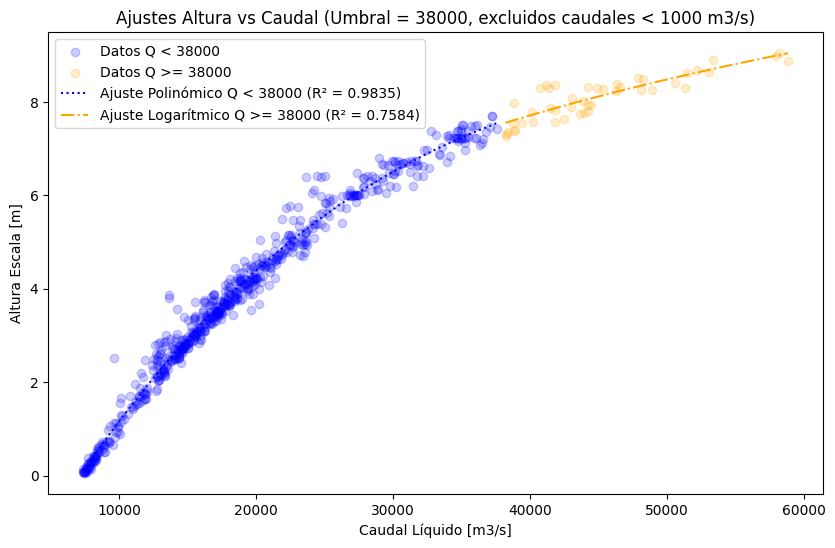

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Monta tu Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 2602 - Aforos Corrientes.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')






# Definir el umbral
Umbral = 38000

# Definir funciones de ajuste
def potencial(x, a, b):
    return a * x ** b

def polinomica(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def logaritmica(x, a, b):
    return a * np.log(x) + b

# Filtrar valores no nulos y caudales menores a 1000
mask = ~df['Caudal Líquido [m3/s]'].isna() & ~df['Altura Escala [m]'].isna() & (df['Caudal Líquido [m3/s]'] >= 1000)
caudal = df['Caudal Líquido [m3/s]'][mask]
altura = df['Altura Escala [m]'][mask]

# Dividir en dos subconjuntos según el caudal
caudal_menor = caudal[caudal < Umbral]
altura_menor = altura[caudal < Umbral]

caudal_mayor = caudal[caudal >= Umbral]
altura_mayor = altura[caudal >= Umbral]

# Función para realizar el ajuste y calcular R²
def ajustar_modelo(func, x, y):
    params, _ = curve_fit(func, x, y)
    y_pred = func(x, *params)
    r2 = r2_score(y, y_pred)
    return params, r2, y_pred

# Ajustes para caudal menor a Umbral
params_pot_menor, r2_pot_menor, altura_pot_menor = ajustar_modelo(potencial, caudal_menor, altura_menor)
params_pol_menor, r2_pol_menor, altura_pol_menor = ajustar_modelo(polinomica, caudal_menor, altura_menor)
params_log_menor, r2_log_menor, altura_log_menor = ajustar_modelo(logaritmica, caudal_menor, altura_menor)

# Ajustes para caudal mayor o igual a Umbral
params_pot_mayor, r2_pot_mayor, altura_pot_mayor = ajustar_modelo(potencial, caudal_mayor, altura_mayor)
params_pol_mayor, r2_pol_mayor, altura_pol_mayor = ajustar_modelo(polinomica, caudal_mayor, altura_mayor)
params_log_mayor, r2_log_mayor, altura_log_mayor = ajustar_modelo(logaritmica, caudal_mayor, altura_mayor)

# Mostrar las expresiones de los ajustes y R2 en la consola
print(f"Ajuste Potencial para Q < {Umbral}: y = {params_pot_menor[0]:.2f} * x^{params_pot_menor[1]:.2f} (R² = {r2_pot_menor:.4f})")
print(f"Ajuste Polinómico para Q < {Umbral}: y = {params_pol_menor[0]:.2e}*x^3 + {params_pol_menor[1]:.2e}*x^2 + {params_pol_menor[2]:.2e}*x + {params_pol_menor[3]:.2f} (R² = {r2_pol_menor:.4f})")
print(f"Ajuste Logarítmico para Q < {Umbral}: y = {params_log_menor[0]:.2f}*ln(x) + {params_log_menor[1]:.2f} (R² = {r2_log_menor:.4f})\n")

print(f"Ajuste Potencial para Q >= {Umbral}: y = {params_pot_mayor[0]:.2f} * x^{params_pot_mayor[1]:.2f} (R² = {r2_pot_mayor:.4f})")
print(f"Ajuste Polinómico para Q >= {Umbral}: y = {params_pol_mayor[0]:.2e}*x^3 + {params_pol_mayor[1]:.2e}*x^2 + {params_pol_mayor[2]:.2e}*x + {params_pol_mayor[3]:.2f} (R² = {r2_pol_mayor:.4f})")
print(f"Ajuste Logarítmico para Q >= {Umbral}: y = {params_log_mayor[0]:.2f}*ln(x) + {params_log_mayor[1]:.2f} (R² = {r2_log_mayor:.4f})")

# Graficar
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.scatter(caudal_menor, altura_menor, color='blue', label=f'Datos Q < {Umbral}', alpha=0.2)
ax1.scatter(caudal_mayor, altura_mayor, color='orange', label=f'Datos Q >= {Umbral}', alpha=0.2)
ax1.set_xlabel('Caudal Líquido [m3/s]')
ax1.set_ylabel('Altura Escala [m]')
ax1.set_title(f'Ajustes Altura vs Caudal (Umbral = {Umbral}, excluidos caudales < 1000 m3/s)')

# Generar valores de x para las curvas de ajuste
caudal_fit_menor = np.linspace(caudal_menor.min(), caudal_menor.max(), 100)
caudal_fit_mayor = np.linspace(caudal_mayor.min(), caudal_mayor.max(), 100)

# Agregar las curvas de ajuste
#ax1.plot(caudal_fit_menor, potencial(caudal_fit_menor, *params_pot_menor), color='blue', linestyle='--',
#         label=f'Ajuste Potencial Q < {Umbral} (R² = {r2_pot_menor:.4f})')
ax1.plot(caudal_fit_menor, polinomica(caudal_fit_menor, *params_pol_menor), color='blue', linestyle=':',
         label=f'Ajuste Polinómico Q < {Umbral} (R² = {r2_pol_menor:.4f})')
#ax1.plot(caudal_fit_menor, logaritmica(caudal_fit_menor, *params_log_menor), color='blue', linestyle='-.',
#         label=f'Ajuste Logarítmico Q < {Umbral} (R² = {r2_log_menor:.4f})')

#ax1.plot(caudal_fit_mayor, potencial(caudal_fit_mayor, *params_pot_mayor), color='orange', linestyle='--',
#         label=f'Ajuste Potencial Q >= {Umbral} (R² = {r2_pot_mayor:.4f})')
#ax1.plot(caudal_fit_mayor, polinomica(caudal_fit_mayor, *params_pol_mayor), color='red', linestyle=':',
#         label=f'Ajuste Polinómico Q >= {Umbral} (R² = {r2_pol_mayor:.4f})')
ax1.plot(caudal_fit_mayor, logaritmica(caudal_fit_mayor, *params_log_mayor), color='orange', linestyle='-.',
         label=f'Ajuste Logarítmico Q >= {Umbral} (R² = {r2_log_mayor:.4f})')

ax1.legend()
plt.show()

## El Colorado

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


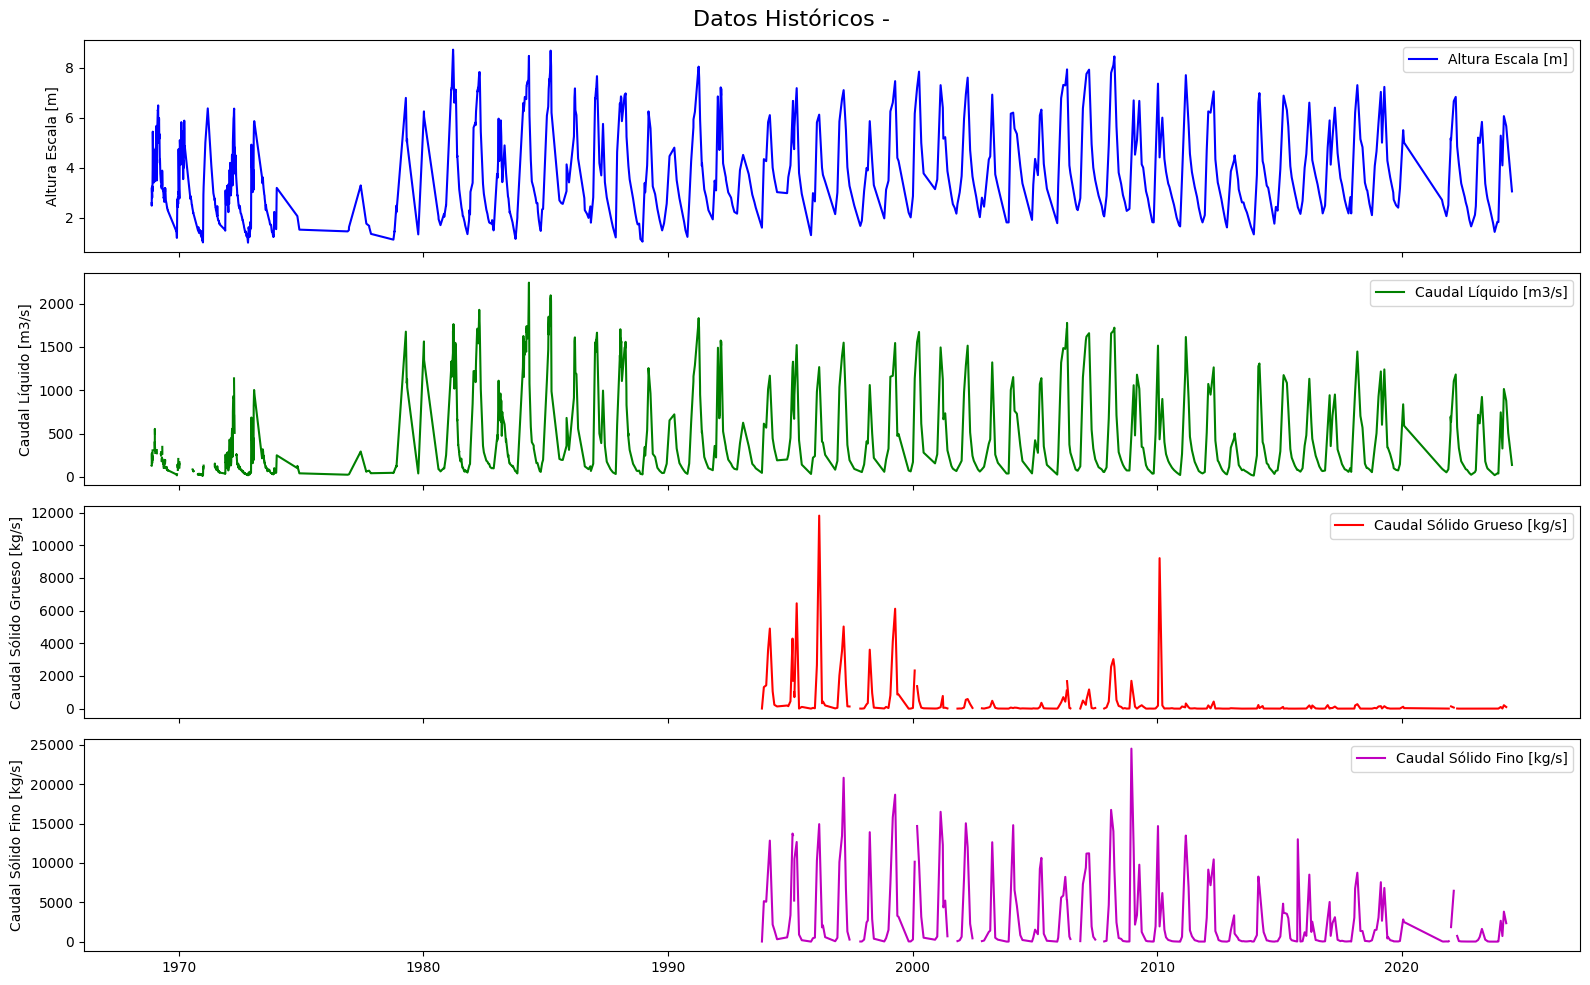

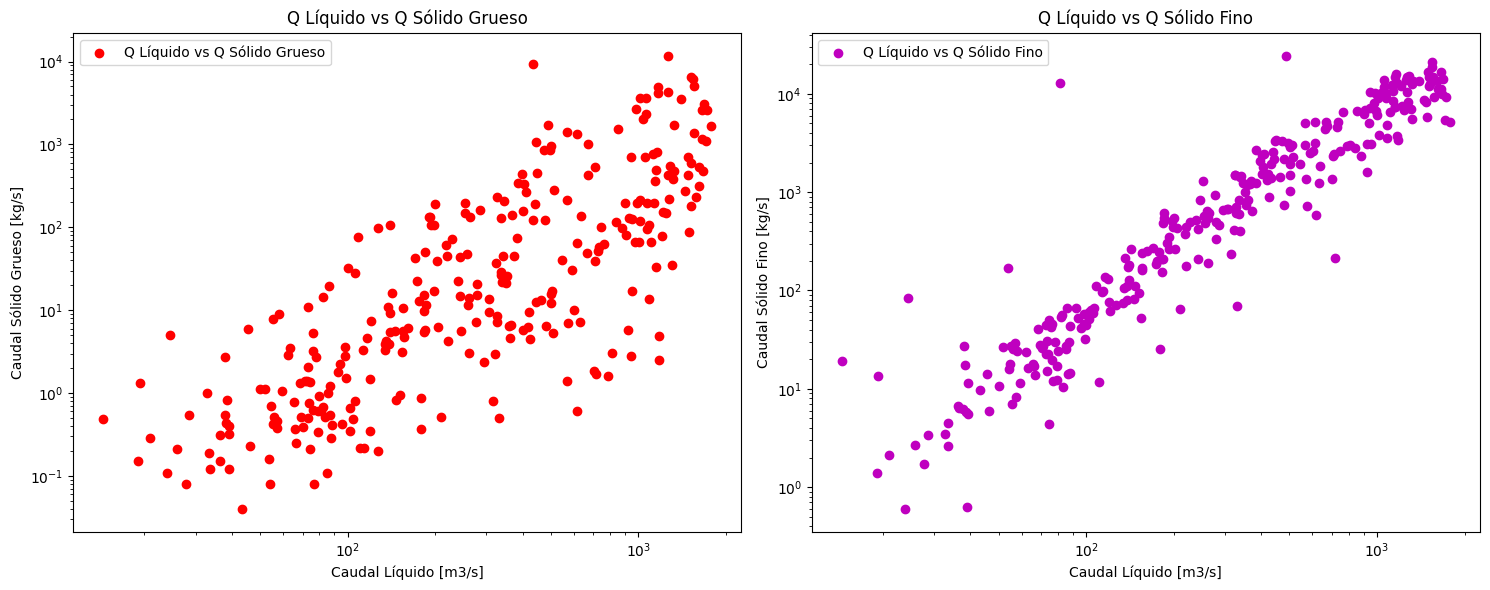

In [ ]:
# Paso 1: Montar Google Drive
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

# Monta tu Google Drive
drive.mount('/content/drive')

# Paso 2: Leer el archivo CSV desde tu Google Drive
file_path = '/content/drive/My Drive/00_CID/Vitco/DatosSed/Historicos-Estacion 2602 - Aforos El Colorado.csv'
df = pd.read_csv(file_path, sep=';', skiprows=2)

# Renombrar las columnas para facilitar el trabajo
df.columns = ['Fecha y Hora', 'Altura Escala [m]', 'Caudal Líquido [m3/s]', 'Caudal Sólido Grueso [kg/s]', 'Caudal Sólido Fino [kg/s]']

# Convertir la columna de fecha a tipo datetime
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'], format='%d/%m/%Y %H:%M')

# Paso 3: Graficar cada variable en función del tiempo
fig, axs = plt.subplots(4, 1, figsize=(16, 10), sharex=True)
fig.suptitle('Datos Históricos - ', fontsize=16)

# Altura Escala
axs[0].plot(df['Fecha y Hora'], df['Altura Escala [m]'], color='b', label='Altura Escala [m]')
axs[0].set_ylabel('Altura Escala [m]')
axs[0].legend()

# Caudal Líquido
axs[1].plot(df['Fecha y Hora'], df['Caudal Líquido [m3/s]'], color='g', label='Caudal Líquido [m3/s]')
axs[1].set_ylabel('Caudal Líquido [m3/s]')
axs[1].legend()

# Caudal Sólido Grueso
axs[2].plot(df['Fecha y Hora'], df['Caudal Sólido Grueso [kg/s]'], color='r', label='Caudal Sólido Grueso [kg/s]')
axs[2].set_ylabel('Caudal Sólido Grueso [kg/s]')
axs[2].legend()

# Caudal Sólido Fino
axs[3].plot(df['Fecha y Hora'], df['Caudal Sólido Fino [kg/s]'], color='m', label='Caudal Sólido Fino [kg/s]')
axs[3].set_ylabel('Caudal Sólido Fino [kg/s]')
axs[3].legend()

plt.tight_layout()
plt.show()


# Paso 4: Graficar Caudal Líquido vs Caudal Sólido Grueso y Fino en escala log-log
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Caudal Líquido vs Caudal Sólido Grueso
ax1.scatter(df['Caudal Líquido [m3/s]'], df['Caudal Sólido Grueso [kg/s]'], color='r', label='Q Líquido vs Q Sólido Grueso')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Caudal Líquido [m3/s]')
ax1.set_ylabel('Caudal Sólido Grueso [kg/s]')
ax1.set_title('Q Líquido vs Q Sólido Grueso')
ax1.legend()

# Caudal Líquido vs Caudal Sólido Fino
ax2.scatter(df['Caudal Líquido [m3/s]'], df['Caudal Sólido Fino [kg/s]'], color='m', label='Q Líquido vs Q Sólido Fino')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Caudal Líquido [m3/s]')
ax2.set_ylabel('Caudal Sólido Fino [kg/s]')
ax2.set_title('Q Líquido vs Q Sólido Fino')
ax2.legend()

plt.tight_layout()
plt.show()